In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from keras.models import Sequential
from keras.layers import LSTM,GRU, SimpleRNN
from keras.layers import Dense
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline
warnings.filterwarnings('ignore')

In [32]:
# 사용할 데이터 불러오기
# 1. 삼성전자의 종가 전체를 불러온 후, 최근 10년치 사용
# 2. 거시경제지표 데이터 사용-(M2통화량, 종합소비자물가지수, 실질 GDP)

# 삼성전자 주가 데이터 불러오기
stock_name = fdr.DataReader('005930').reset_index()
stock_name.columns = ['DATE', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change']

# 경제 지표 데이터 불러오기
df_a = fdr.DataReader(['KORCPIALLMINMEI', 'M2','KORRGDPR'], 
                      start='1997', data_source='fred').reset_index()

# 두 데이터 취합하기
df_total = pd.merge(stock_name,df_a, on='DATE', how='left')

# 최근 약 10년치 사용
df_total = df_total.fillna(0)

In [33]:
# 데이터 전처리
# 1. 데이터의 값들을 동일한 값의 범위로 맞춰주기 위한 표준화 작업 진행
# 2. 딥러닝 모델에 맞게 변환하기 위한 구조 변환 작업 진행
# 3. 데이터를 훈련데이터(80%)와 예측데이터(20%)로 분리하여 진행

# 훈련데이터와 예측데이터로 분리
lst_vars = ['KORCPIALLMINMEI', 'M2','KORRGDPR','M2', 'Close']

train_size = int(df_total.shape[0]*0.8)
train = df_total[:train_size].fillna(0)
test = df_total[train_size:].fillna(0)

# 딥러닝 모델의 구조에 맞게 데이터 변환
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps

		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 1
n_features = len(lst_vars)

scaler = StandardScaler()
X, y = split_sequence(train[lst_vars].values, n_steps)
scaler = StandardScaler()
testX, testy = split_sequence(test[lst_vars].values, n_steps)

X = X.reshape((X.shape[0], X.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [34]:
# 모델링
# 1. RNN/ LSTM/ GRU 모델들을 각각 구성한
# 2. 이전 단계에서 만든 훈련 데이터 활용하여 모델을 학습
# 3. 학습시킨 모델에 예측 데이터를 투입하여 예측값 생성
# 4. 예측 데이터의 실제값과 예측값을 비교하여, 성능평가 및 결과 시각화

# RNN 모델 학습 및 예측
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

pred_rnn = model.predict(testX, verbose=0)

In [35]:
# LSTM 모델 학습 및 예측
n_steps_multi = 7

scaler = StandardScaler()
X, y = split_sequence(train[lst_vars].values, n_steps_multi)
scaler = StandardScaler()
testX, testy = split_sequence(test[lst_vars].values, n_steps_multi)

X = X.reshape((X.shape[0], X.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_multi, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

pred_lstm_multi= model.predict(testX, verbose=0)

In [36]:
# GRU 모델 학습 및 예측
model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_multi, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

pred_gru_multi = model.predict(testX, verbose= 1)

38/38 [==============================] - 0s 3ms/step


In [37]:
# 최종 성능 평가 예측을 위한 지표 생성
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return(mape, rmse)

result_multi = pd.DataFrame([
             forecast_accuracy(pred_rnn, test['Close'].values),
             forecast_accuracy(pred_lstm_multi, test['Close'].values),
             forecast_accuracy(pred_gru_multi, test['Close'].values)],
            index = ['rnn','lstm','gru'],
            columns= ['mape','rmse'])
result_multi

,mape,rmse
rnn,0.254628,19054.574988
lstm,0.260641,19622.402634
gru,0.255185,19079.560564


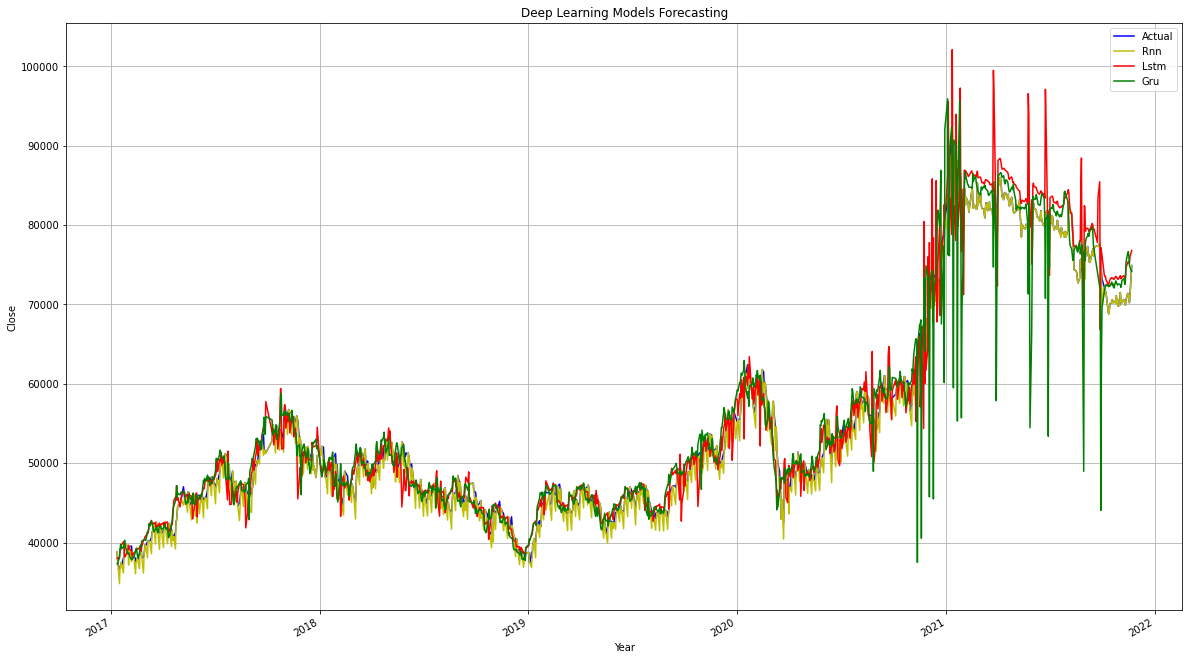

In [38]:
# 모델 별 예측 결과 시각화
lst_date_all = df_total['DATE'].values
lst_date_test = test['DATE'].values
data = df_total['Close'].values

# 실측치와 예측치 그래프
plt.figure(figsize=(20,12))
plt.plot(lst_date_test[:-7], test['Close'].values[:-7], color='b')
plt.plot(lst_date_test[:-7], pred_rnn[:-6], color='y')
plt.plot(lst_date_test[:-7], pred_lstm_multi, color='r')
plt.plot(lst_date_test[:-7], pred_gru_multi, color='g')
plt.title('Deep Learning Models Forecasting')
plt.gcf().autofmt_xdate()
plt.legend([])


plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend(['Actual','Rnn','Lstm','Gru'])
plt.show()